In [55]:
import numpy as np
import matplotlib.pyplot as plt
from Rocket import Rocket
from Dynamics import Dynamics
from Plot3D import Plot3D
from MPC import MPC
from Adaptive import Adaptive
from Quat import Quat

import time
import pylab as pl
from IPython import display

#np.set_printoptions(precision=3,suppress=True)

In [56]:
#https://www.spacex.com/vehicles/falcon-9/

falcon = Rocket("Falcon 9")
falcon.mass = 1 #kg
falcon.height = 70 #m
falcon.radius = 3.7/2 #m
falcon.max_thrust = 7607e3 #N
falcon.cg_thrust_length = 20 #m
falcon.cg_cp_length = 15 #m
falcon.Cd = 10000.82

falcon.load()
dynamics = Dynamics(falcon)
mpc = MPC(falcon)
mpc.tf = 20

x0 = [0,0,100,0,0,0,10]



In [57]:
class Position(Adaptive):
    def __init__(self):
        eta = np.diag([0.1,0.1,0.1])*10
        lam = 2
        phi = 10
        alpha = 2.5 #frequency of switching
        Cd = 0.1
        A = lambda q,dq: np.array([[0,0,-9.81]]).T #-Cd*np.abs(dq)*dq
        B = np.diag([1,1,1])
        
        super().__init__(eta,lam,phi,alpha,A,B)

    def filteredInput(self,q,dq):
        control = self.input(q,dq)
        for i in range(len(control)):
            if control[i,0] <= 0:
                control[i,0] = 0
        return control
position = Position()




# ==========================================================
# = Solver Results                                         =
# ==========================================================
# ----------------------------------------------------------
#   Problem Information
# ----------------------------------------------------------
Problem: 
- Lower bound: -inf
  Upper bound: inf
  Number of objectives: 1
  Number of constraints: 1312
  Number of variables: 1206
  Sense: unknown
# ----------------------------------------------------------
#   Solver Information
# ----------------------------------------------------------
Solver: 
- Status: ok
  Message: Ipopt 3.11.1\x3a Optimal Solution Found
  Termination condition: optimal
  Id: 0
  Error rc: 0
  Time: 0.5549516677856445
# ----------------------------------------------------------
#   Solution Information
# ----------------------------------------------------------
Solution: 
- number of solutions: 0
  number of solutions displayed: 0
[[0

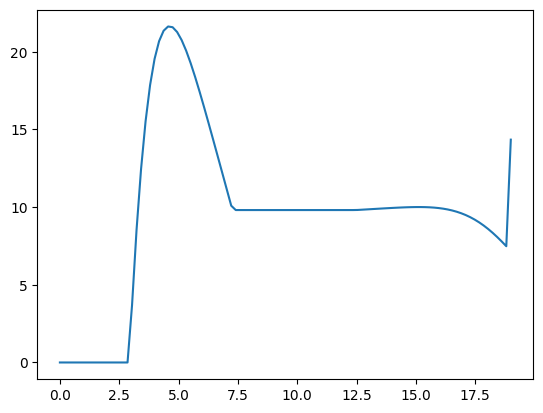

In [58]:
from scipy.integrate import solve_ivp
N = 1000
tf = 20
t_eval = np.linspace(0,tf,N+2)

for i in range(1):
    mpc_nominal = mpc.run(x0[:-1])
    plt.figure()
    plt.plot(mpc_nominal[9],mpc_nominal[2],label="x")
    for i in range(len(mpc_nominal)-1):
        mpc_nominal[i] = np.interp(t_eval,mpc_nominal[9],mpc_nominal[i])

    for i in range(N):
        x,y,z,dx,dy,dz,phi= x0
        q = np.array([[x,y,z]]).T
        dq = np.array([[dx,dy,dz]]).T

        u_nominal = np.array([[mpc_nominal[0][i],mpc_nominal[1][i],mpc_nominal[2][i]]]).T
        position.ref = np.array([[mpc_nominal[3][i],mpc_nominal[4][i],mpc_nominal[5][i]]]).T
        position.dref = np.array([[mpc_nominal[6][i],mpc_nominal[7][i],mpc_nominal[8][i]]]).T
        position.ddref = u_nominal + np.array([[0,0,-9.81]]).T
        u = position.input(q,dq)

        d = np.random.uniform(low=-1, high=1, size=(3,1))*1
        
        def ode(t,state):
            x,y,z,dx,dy,dz,phi= state

            position.phi = phi
        
            Cd = 0.1
            q = np.array([[x,y,z]]).T
            dq = np.array([[dx,dy,dz]]).T

            #random vector
            
            ddr = np.array([[0,0,-9.81]]).T + u + d #-Cd*np.abs(dq)*dq
            
            phi_dot = position.phi_dot()
            return [dx,dy,dz,ddr[0,0],ddr[1,0],ddr[2,0],phi_dot]

        sol = solve_ivp(ode,[0,tf/N],x0)
        x0 = sol.y[:,-1]
        

    x,y,z,dx,dy,dz,phi= x0
    q = np.array([[x,y,z]]).T
    dq = np.array([[dx,dy,dz]]).T

    u = position.input(q,dq)



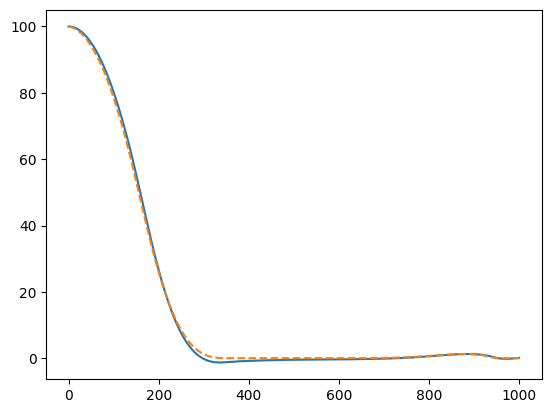

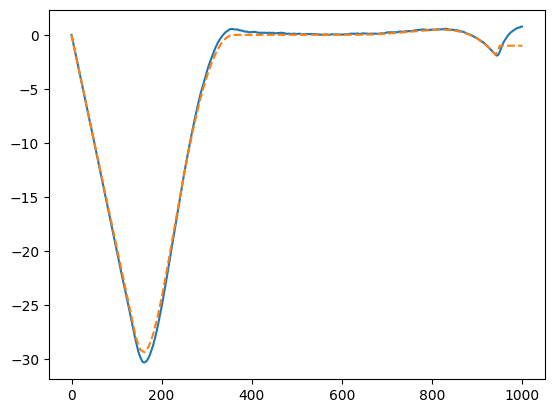

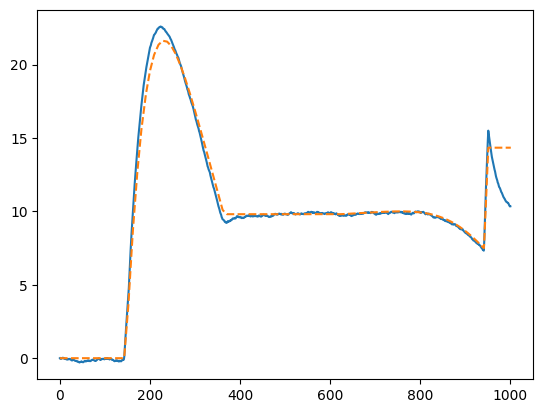

In [59]:
plt.plot(position.states[2,1:])
plt.plot(mpc_nominal[5],'--')

plt.figure()

plt.plot(position.dstates[2,1:])
plt.plot(mpc_nominal[8],'--')

plt.figure()

plt.plot(position.inputs[2,1:])
plt.plot(mpc_nominal[2],'--')